<a href="https://colab.research.google.com/github/cikufa/lateralcontrol_1/blob/shekoufeh/Sarah_last_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# libraries
#saarhin
#tasks: 1-action , preview dist in in reward/ 2- one step ahead in network input/ 3- reward every 5 iteration 
import numpy as np 
import math
import matplotlib.pyplot as plt
import shapely.geometry as geom
from shapely.ops import nearest_points
import tensorflow as tf
from tensorflow import keras
from keras.optimizers import adam_v2
import tensorflow_probability as tfp
import os
from keras.layers import Dense
!pip install xlsxwriter
import xlsxwriter
#from keras.optimizers import adam
from google.colab import drive
drive.mount('/content/drive')


     |████████████████████████████████| 149 kB 4.1 MB/s 
Mounted at /content/drive


In [2]:
class GenericNetwork(keras.Model):
    def __init__(self, n_actions, fc1_dims, fc2_dims, name, chkpt_dir="/tmp/actor_critic"):
        super(GenericNetwork, self).__init__()
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.model_name = name
        self.checkpoint_dir = chkpt_dir
        self.checkpoint_file = os.path.join(self.checkpoint_dir, name)

        self.fc1 = Dense(self.fc1_dims, activation='relu')
        self.fc2 = Dense(self.fc2_dims, activation='relu')
        self.fc3 = Dense(n_actions)
        
        #self.v = Dense(1, activation=None)
        #continous action is represented as a normal distribution that is characterized with 2 quantities: a mean and a standard deviation 
        #self.pi = Dense(n_actions=2, activation='softmax')

    def call(self, state):
        x = self.fc1(state)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [3]:
class Agent:
    def __init__(self, layer1_dim=128, layer2_dim=64, n_actions=2, alpha_A=0.00003, alpha_C=0.00005, gamma=0.99):
        self.layer1_dim = layer1_dim
        self.layer2_dim = layer2_dim
        self.n_actions = n_actions
        self.gamma = gamma
        self.alpha_A = alpha_A 
        self.alpha_C= alpha_C
        self.action = None
        self.log_prob= None
        
        self.actor = GenericNetwork(n_actions, layer1_dim, layer2_dim, "actor")
        self.actor.compile(optimizer=adam_v2.Adam(learning_rate=alpha_A))
        self.critic = GenericNetwork(1, layer1_dim, layer2_dim, "critic")
        self.critic.compile(optimizer=adam_v2.Adam(learning_rate=alpha_C))
        self.aloss= []
        self.closs=[]

    def choose_action(self, observation): #obs shape (1,2)
        state = tf.convert_to_tensor([observation]) #state shape (1,1,2)
        pars= self.actor(state) #mean and standard deviation that make action probs
        pars= np.asarray(tf.squeeze(pars)).reshape(1,2)  
        sigma , mu = np.hsplit(pars , 2)
        sigma = tf.exp(sigma) #get rid of negative sigma
        #sigma= abs(sigma)
        action_probabilities = tfp.distributions.Normal(mu , sigma) #normal distribution with mu,sigma pars  
        #log_prob = action_probabilities.log_prob(action_probabilities) #log (gonna be used for gradient)
        action = action_probabilities.sample() #choose action (most likely to be chosen with higher probability)
        action = tf.tanh(action) * 0.07 #action: continuous num in range(-0.07, 0.07)((-4,4) degree_
        self.action = action  
        return action #cast tensor to numpy(openAI gym doesnt take tensor)

    # def save_models(self):
    #     #print('... saving models ...')
    #     self.actor.save_weights(self.actor.checkpoint_file)
    #     self.critic.save_weights(self.critic.checkpoint_file)
    # def load_models(self):
    #     print('... loading models ...')
    #     self.actor.load_weights(self.actor.checkpoint_file)
    #     self.critic.load_weights(self.critic.checkpoint_file)
        
    def learn(self, state, reward, state_,done):
        #print("state before ")
        state = tf.convert_to_tensor([state], dtype=tf.float32)
        state_ = tf.convert_to_tensor([state_], dtype=tf.float32)
        reward = tf.convert_to_tensor(reward, dtype=tf.float32) # not fed to NN -> no need to reshape
        with tf.GradientTape(persistent=True) as tape:
            state_value = self.critic(state)
            state_value_ = self.critic(state_)
            state_value = tf.squeeze(state_value) #squeeze Removes dims of size 1 from the shape of a tensor.
            state_value_ = tf.squeeze(state_value_)
            pars= self.actor(state)
            #pars= np.asarray(tf.squeeze(pars)).reshape(1,2)
            #mu , sigma= np.hsplit(pars , 2)
            #mu = np.squeeze(mu)
            #sigma = np.squeeze(sigma)
            mu = pars[0,0]
            sigma = pars[0,1]
            #print(sigma)
            #sigma = tf.exp(sigma)
            #print(sigma)
            action_probs = tfp.distributions.Normal(mu, abs(sigma)) #policy 
            log_prob = action_probs.log_prob(self.action[0,0] )
            #print(mu,sigma)
            #print(log_prob)
                      
            #TD error: 
            TD= self.gamma*state_value_*(1-int(done)) - state_value 
            delta = reward + TD #1-done: terminal stRemoves dimensions of size 1 from the shape of a tensor.ate zero effect 
            actor_loss = (-log_prob*delta)            
            critic_loss = (delta**2) 
            #print("sig", sigma , "ac", actor_loss, "cr", critic_loss)
  
            
        gradient1 = tape.gradient(actor_loss, self.actor.trainable_variables)
        
        self.actor.optimizer.apply_gradients((grad , var) for (grad , var) in zip(gradient1, self.actor.trainable_variables) if grad is not None)
        #if grad is not None
            
        gradient2 = tape.gradient(critic_loss, self.critic.trainable_variables)
        self.critic.optimizer.apply_gradients((grad , var) for (grad , var) in zip(gradient2, self.critic.trainable_variables) if grad is not None)
        # if grad is not None
        return critic_loss, actor_loss, gradient1


In [7]:
class lateralenv:
    def __init__(self, data, data_length, n_episodes, episode_length):
        # constants
        dt = 0.01
        vx = 10
        iz = 2278.8
        m = 1300
        a1 = 1;
        a2 = 1.5
        caf = 60000
        car = 60000
        cb = -(caf + car);
        cr = (-a1 * caf + a2 * car) / vx
        db = -(a1 * caf - a2 * car);
        dr = -(a1 ** 2 * caf + a2 ** 2 * car) / vx
        cd = caf;
        dd = a1 * caf
        self.constants = [dt, vx, iz, m, cb, cr, db, dr, cd, dd]

        self.data_length = data_length
        self.n_episodes = n_episodes
        self.episode_length = episode_length
        self.episode_length_cnt = episode_length

        self.x = data[0:data_length, 0]
        self.y = data[0:data_length, 1]

        #self.road = geom.LineString(zip(self.x[:100], self.y[:100]))
        self.road = geom.LineString(zip(self.x, self.y))
        self.heading_angle = [np.arctan2(self.y[i + 1] - self.y[i], self.x[i + 1] - self.x[i]) for i in
                         range(self.data_length-1)] # rad [-1.57, 1.57]
        self.heading_angle.insert(0, self.heading_angle[0])  # append last value to adjust the shape
        self.heading_angle = np.asfarray(self.heading_angle).reshape(self.data_length, 1)

        # ______________________________________________init vars_____________________________________________________________
        
        # vy0 = 0; r0 = 0;
        # x0 = self.x[0]; y0 = self.y[0]
        # psi0 = self.heading_angle[0]
        # self.vars = np.array([[vy0, r0, x0, y0, psi0]], dtype='float64').T  # 1,5 vars0
        # self.vars_ = np.zeros((5, 1), dtype='float64')  # is only updated for normal step
        # self.vars_tmp = vars0  # is updated for both normal step and preview step
        
        self.score = 0
        self.index = 0
        self.Done = 0
        self.coordinates = []
        self.nearestPiontCheck = []
        self.vys = []
        self.vymax = -10
        self.vars = np.zeros((5, 1))
        self.vars_ = np.zeros((5, 1), dtype='float64')  # is only updated for normal step
        self.vars_tmp= np.zeros((5, 1)) # is updated for both normal step and preview step
                                
        # self.point0 = geom.Point(x0, y0)
        # limited_dist0, limited_angle_diff0, _, _ = self.dist_diff(ep=0, limit_dist=1, limit_ang=0, stp=0)
        # self.preview(action=0, preview=1)
        # future_limited_dist0, future_limited_ang0, _, _ = self.dist_diff(ep=0, limit_dist=1, limit_ang=0, stp=0)  # sefr
        # # self.state0= np.array([limited_dist0,limited_angle_diff0]) #(1,2)
        # self.state0 = np.array([limited_dist0, limited_angle_diff0, limited_dist0, limited_angle_diff0])  # (1,4)
        # # print("state0" ,limited_dist0,limited_angle_diff0, limited_dist0,limited_angle_diff0)

    # ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

    def dist_diff(self, ep, limit_dist, limit_ang, stp, pre_point=geom.Point(0,0)):
        vy, r, x, y, psi = self.vars_tmp
        ##1: based on where the car is supposed to be on this iteration
        # self.index = self.index+1
        # dist = self.data[self.index, 0:2] - coordinate_ #(1,2)
        # angle_diff= self.data[self.index,2] - psi_
        # ________________________________________________________________________

        ## 2: based on where the car is supposed to be if the driven distance was along the road
        # driving_distance= (vy**2 + vx**2)**0.5 *dt #driving angle : psi_
        # #(dx^2+dy^2)^0.5= distance , dy=1.5dx -> (3.25dx^2)*0.5 = distance -> 1.802 dx = distance
        # dx= driving_distance / math.sqrt(3.25); dy= dx*1.5
        # dist= ((dx - x_)**2 + (dy- y_)**2)**0.5
        # angle_diff =
        # _______________________________________________________________________

        # 3: based on car's vertical disance with the road
        point = geom.Point(x, y)
        dist = point.distance(self.road_ep)
        #dist_z = math.sqrt((y - self.y0) ** 2 + (x - self.x0) ** 2)
        limited_dist = max(dist, 0.01)
        limited_dist = min(limited_dist, 100)

        nearestP = nearest_points(self.road_ep, point)[0]
        self.nearestPiontCheck.append(np.array(nearestP))
        self.nearestPiontCheck.append(np.array(point))
        road_slope = (nearestP.y-pre_point.y)/(nearestP.x-pre_point.x) if (nearestP.x-pre_point.x) !=0 else (nearestP.y-pre_point.y)/0.001
        angle_diff = abs(np.arctan2((road_slope-psi), 1))[0]
        #angle_diff = abs(np.arctan2((nearestP.y-pre_point.y),nearestP.x-pre_point.x)- psi[0]) #sara 

        #index, = np.where(self.road_ep == nearestP)
        # print("index", index)
        #angle_diff=  np.arctan2(self.road_ep[index+1][1]-self.road_ep[index][1], self.road_ep[index+1][0]- self.road_ep[index][0]) - psi
        # angle_diff = abs((np.cos(x / 100) / 4 - psi)[0])
        limited_angle_diff = max(angle_diff, 0.005)
        # limited_angle_diff=min(limited_angle_diff , 100) #-> max reward = 5000, min reward 5e-5

        # print("point", point,"nearest p", nearestP.coords[0], "angle_diff", angle_diff)

        # debug
        # p_buffer=np.zeros((500, 500)) ; dist_buffer=np.zeros((500, 500,3))
        # assert p_buffer[ep][stp][0] != point.coords[0][0] , "equal points !!"
        # assert dist_buffer[ep][stp] != [dist, angle_diff, dist_z] , 'equal dist !!'
        # p_buffer[ep][stp]= point.coords[0][0]
        # dist_buffer[ep][stp]= [dist, angle_diff, dist_z]

        # print("point", point)
        # print("dist" , dist, "angle", angle_diff, "Z  ", dist_z)

        if limit_dist == 1:
            if limit_ang == 1:
                return limited_dist, limited_angle_diff, nearestP
            elif limit_ang == 0:
                return limited_dist, angle_diff, nearestP
        else:
            return dist, angle_diff, nearestP

    # +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

    def preview(self, action,
                preview):  # in this version the preview point is calculated using the updated self.vars. also try with non-updated vars
        dt, vx, iz, m, cb, cr, db, dr, cd, dd = self.constants
        vy, r, x, y, psi = np.vsplit(self.vars, 5)
        if preview == 1:
            dt = 0.3
        if preview == 0:
            dt = 0.1
        # calc new state
        par_mat1 = np.array([[cb / (m * vx), cr / m - vx, 0, 0, 0],
                             [db / (iz * vx), dr / iz, 0, 0, 0],
                             [-math.sin(psi), 0, 0, 0, 0],
                             [math.cos(psi), 0, 0, 0, 0],
                             [0, 1, 0, 0, 0]])

        par_mat2 = np.array([[cd * action / m], [dd * action / iz], [vx * math.cos(psi)],
                             [vx * math.sin(psi)], [0]], dtype='float64')

        var_dot_mat = par_mat1 @ self.vars + par_mat2  # (5,1)= (5,5)@(5,1)+(5,1)
        self.vars_tmp = self.vars + dt * var_dot_mat  # (5,1) =(5,1)+(5,1)

        if preview == 0:
            self.vars_ = self.vars_tmp

        return

    # +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

    def step(self, action, stp_cnt, pre_point):
        self.preview(action, preview=0)
        # print("____________________________NOT preview_________________________")
        dist, angle_diff, pre_point = lateralenv.dist_diff(self, ep=0, limit_dist=1, limit_ang=0, stp=stp_cnt, pre_point=pre_point)
        # print("step :  dist" , dist, "angle", angle_diff, "Z  ", dist_z)
        self.preview(action, preview=1)
        # print("____________________________preview______________________________")
        future_dist, future_angle_diff, _ = lateralenv.dist_diff(self, ep=0, limit_dist=1, limit_ang=0,
                                                                             stp=stp_cnt)
        # print(stp_cnt)

        # %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% calc reward %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

        # 3: based on car's vertical disance with the road

        # reward = - dist_z*future_dist_z/10000
        # reward = - dist_z/100
        weight = 10
        action_weight = -10
        preview_weight = 0.1
        # print("point", point, dist, "ang", angle_diff)
        # print("dist", dist, "ang", angle_diff)
        k1 = 1 / (dist ** 2 + angle_diff ** 2)
        k2 = 1 / (future_dist ** 2 + future_angle_diff ** 2)
        #reward = weight * k1 + preview_weight * k2  # + action_weight * int(action)
        reward_calc = f'{weight} * {k1} + {preview_weight}*{k2} + {action_weight} * {action}'
        # reward = - angle_diff

        ## 4: Sarah test
        # ------------------------
        reward = k1 * weight + k2 * preview_weight 

        # for next step
        # self.coordinates.append(self.vars[2:4,0])
        # self.vys.append(self.vars[0])
        # self.vars = self.vars_

        # print("dist", dist,"angd", angle_diff, "p dist",future_dist, "p angd", future_angle_diff)
        self.state_ = np.array([dist, angle_diff, future_dist, future_angle_diff])  # real state (not limited)
        # self.state_ = np.array([dist, angle_diff]) #real state (not limited)

        self.vars = self.vars_
        self.coordinates.append(self.vars[2:4, 0])
        self.vys.append(self.vars[0])

        self.episode_length_cnt = self.episode_length_cnt - 1
        if self.episode_length_cnt == 0:
            self.Done = 1

        return self.vars_, self.state_, reward, reward_calc, self.Done, pre_point  # state:(dist, ang_dif)

    # ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

    def render(self, ep, score):

        plt.xlabel("x")
        plt.ylabel("y")
        plt.plot(self.road.coords.xy[0][:], self.road.coords.xy[1][:], 'r')  # road
        plt.plot(np.array(self.coordinates)[:, 0], np.array(self.coordinates)[:, 1], label=score)  # path

        # to check whether the nearest points for a random road works logically
        for i in range(0, len(self.nearestPiontCheck)-10, 300):
            plt.plot([np.array(self.nearestPiontCheck)[i, 0], np.array(self.nearestPiontCheck)[i+1, 0]],
                       [np.array(self.nearestPiontCheck)[i, 1], np.array(self.nearestPiontCheck)[i + 1, 1]], marker='o')
            
        plt.legend()
        if (ep % 1 == 0):
            plt.show()
            plt.savefig(f"drive/MyDrive/RL_lane_following_debug/path{ep}.jpg")
            plt.cla()
        pass

    def reset(self, ep):  # before each episode
        self.Done = 0
        self.episode_length_cnt = self.episode_length

        # a new section of the road excel is selected for each episode
        # in the current version 100 cells from each episode is used for each road
        self.road_ep = geom.LineString(zip(self.x[(ep-1) * self.episode_length:ep * self.episode_length], 
                                        self.y[(ep-1) * self.episode_length:ep * self.episode_length]))
        #print("debug", self.road_ep.coords.shape)
        plt.plot(self.road_ep.coords.xy[:][0], self.road_ep.coords.xy[:][1])
                
        # the car starts on the road
        st_vy = 0; st_r=0;
        st_x = self.x[(ep-1) * 100] + np.random.rand()*3
        st_y = self.y[(ep-1) * 100] + np.random.rand()*3
        st_psi = self.heading_angle[(ep-1)*100]+np.random.rand()*0.1
        st_pre_point = geom.Point(self.road_ep.coords.xy[0][0], self.road_ep.coords.xy[0][1])
        
        point0_ep = geom.Point(st_x, st_y)
        limited_dist0, limited_angle_diff0, _ = self.dist_diff(ep=0, limit_dist=1, limit_ang=0, stp=0)
        self.preview(action=0, preview=1)
        future_limited_dist0, future_limited_ang0, _ = self.dist_diff(ep=0, limit_dist=1, limit_ang=0, stp=0)  # sefr
        state0_ep = np.array([limited_dist0, limited_angle_diff0, limited_dist0, limited_angle_diff0])  # (1,4)
        
        self.vars = np.array([[st_vy, st_r, st_x, st_y, st_psi]], dtype='float64').T
        #self.vars_ = np.zeros((5, 1), dtype='float64')  # is only updated for normal step
        self.vars_tmp = np.array([[st_vy, st_r, st_x, st_y, st_psi]], dtype='float64').T # is updated for both normal step and preview step
        
        # the testing arrays
        self.coordinates = []
        self.nearestPiontCheck = []
         
        return state0_ep, st_pre_point

In [8]:
import pandas as pd
from google.colab import files
import io

# uploaded = files.upload()
# discreate_road_pd = pd.read_csv(io.BytesIO(uploaded['Chaos-generted road.csv']))
# discreate_road_np = discreate_road_pd.to_numpy()
# plt.plot(discreate_road_np[:,0], discreate_road_np[:,1])

uploaded = 'drive/MyDrive/RL_lane_following_debug/Chaos-generted road.csv'
discrete_road_pd = pd.read_csv(uploaded)
discrete_road_np = discrete_road_pd.to_numpy()

# print(discrete_road_np.shape)
# plt.plot(discrete_road_np[:,0], discrete_road_np[:,1])
# plt.show()
# road = geom.LineString(zip(discrete_road_np[:,0], discrete_road_np[:,1]))
# plt.plot(road.coords.xy[0][0:1000], road.coords.xy[1][0:1000],'r')
# plt.show()

1 :____________________________________________________________________________
episode  1 score 660.555864782323 avg_score 660.555864782323 reward 0.00922682106503018


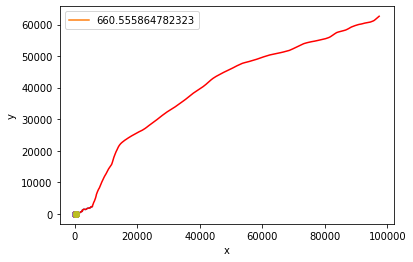

2 :____________________________________________________________________________
episode  2 score 0.5049202765315502 avg_score 330.53039252942733 reward 0.0010097787482010174


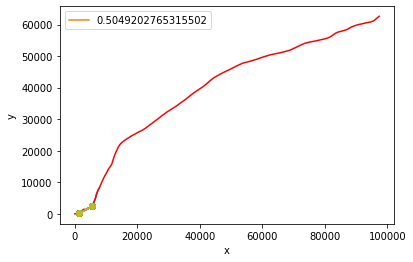

3 :____________________________________________________________________________
episode  3 score 0.5049108446290621 avg_score 220.5218986344946 reward 0.0010097763093095417


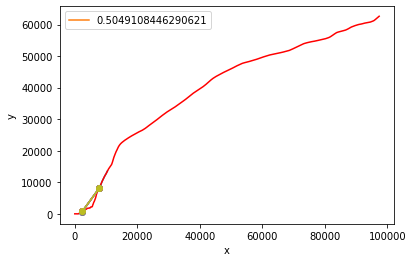

4 :____________________________________________________________________________
episode  4 score 0.5049278441784725 avg_score 165.51765593691556 reward 0.00100978102603876


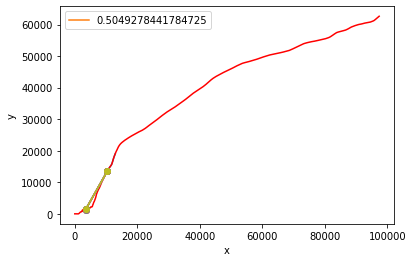

5 :____________________________________________________________________________
episode  5 score 0.5049106370657338 avg_score 132.5151068769456 reward 0.0010097762662991973


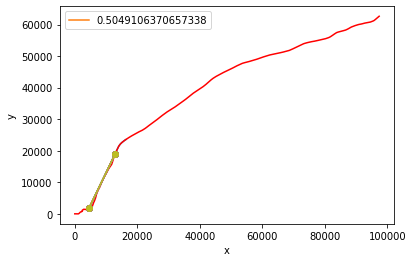

6 :____________________________________________________________________________
episode  6 score 0.5049038932788414 avg_score 110.5134063796678 reward 0.0010097746417638328


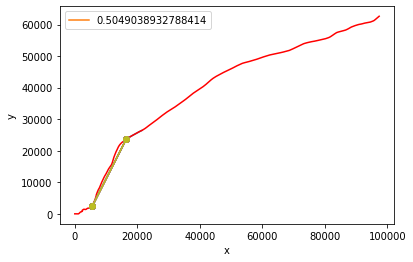

7 :____________________________________________________________________________
episode  7 score 0.5049039438821303 avg_score 94.79790603169842 reward 0.0010097746561537019


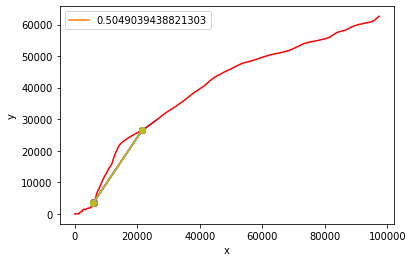

8 :____________________________________________________________________________
episode  8 score 0.5049027242059967 avg_score 83.01128061826186 reward 0.0010097743155076022


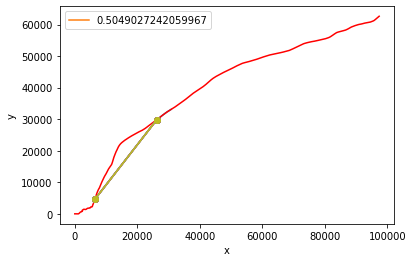

9 :____________________________________________________________________________


In [ ]:
import warnings
warnings.filterwarnings("ignore")

#if __name__ == '__main__':
agent = Agent(layer1_dim=128, layer2_dim=64, n_actions=2, alpha_A=0.0003, alpha_C=0.005, gamma=0.99)
n_episodes = 20

#self.road = self.road[:, 3000] #tmp

data_length = 10000
ep_length = int(data_length / n_episodes)  #500
env = lateralenv(discrete_road_np, data_length, n_episodes, ep_length)

score_history = []
best_score = 0  # reward = 1/positive > 0 -> min score =0
load_checkpoint = False

workbook = xlsxwriter.Workbook('drive/MyDrive/RL_lane_following_debug/log.xlsx')
log = workbook.add_worksheet("ep_per_ep")
log.write(0, 0, "ep / step")
log.write(0, 3, "vy")
log.write(0, 4, "point")
log.write(0, 5, "distance")
log.write(0, 6, "angle_diff")
log.write(0, 7, "road derivative")
log.write(0, 8, "psi")
log.write(0, 9, "reward")
log.write(0, 10, "point dist_diff +  preview point dist_diff + action")

# training________________________________________________________________________________________
cnt = 0
for ep in range(1, n_episodes + 1):

    score = 0
    al = [];
    cl = [];
    rewards = []
    state, pre_point = env.reset(ep)  # (1,2)

    j = 0
    states_ = []
    act_buffer = 0
    print(ep, ":____________________________________________________________________________")
    while not env.Done:
        action = agent.choose_action(state)
        # assert action != act_buffer , "equal actions !!"
        #act_buffer = action

        newvars, state_, reward, reward_calc, Done, pre_point = env.step(action, j, pre_point)
        states_.append(state_)

        score = score + reward
        rewards.append(reward)

        # if not load_checkpoint:
        closs, aloss, grad1 = agent.learn(state, reward, state_, Done)
        # log
        log.write((ep - 1) * ep_length + j + 1, 0, f"{ep} / {j}")
        log.write((ep - 1) * ep_length + j + 1, 3, newvars[0])
        log.write((ep - 1) * ep_length + j + 1, 4, str(newvars[2:4]))
        log.write((ep - 1) * ep_length + j + 1, 5, state_[0])
        log.write((ep - 1) * ep_length + j + 1, 6, state_[1])
        log.write((ep - 1) * ep_length + j + 1, 7, np.cos(newvars[2] / 200)[0] / 4)
        log.write((ep - 1) * ep_length + j + 1, 8, newvars[-1])
        log.write((ep - 1) * ep_length + j + 1, 9, reward)
        log.write((ep - 1) * ep_length + j + 1, 10, reward_calc)

        state = state_
        j += 1  # step counter

    states_ = np.array(states_)
    score_history.append(score)

    # ______________ plot score curve)
    # ep = [i+1 for i in range(i)]
    # x= np.array(ep).reshape(i,1)
    # #score_history= np.array(score_history).reshape(i,1)
    # plt.xlabel("episode")
    # plt.ylabel("score")
    # plt.plot(x, np.array(score_history).reshape(i,1))
    # plt.savefig(figure_file)

    avg_score = np.mean(score_history[-100:])
    if avg_score > best_score:
        best_score = avg_score
    if (ep % 1 == 0):
        print('episode ', ep, 'score', score, 'avg_score', avg_score, 'reward', reward)
        env.render(ep, score)

workbook.close()

if not load_checkpoint:
    ep = [i + 1 for i in range(n_episodes)]
    x = np.array(ep).reshape(n_episodes, 1)
    score_history = np.array(score_history).reshape(n_episodes, 1)
    plt.xlabel("episode")
    plt.ylabel("score")
    plt.plot(x, score_history)
    plt.savefig('scores.png')



# New Section

In [ ]:
# test 
import numpy as np 
import math
import shapely.geometry as geom
import matplotlib.pyplot as plt
from shapely.ops import nearest_points

# x= np.arange(0, 10).reshape(10, 1) 
# y= 50*np.sin(x/200)
# road = geom.LineString(zip(x,y))
# p= geom.Point(314,50)
# print("ggg", p.coords[0][1])
# print("ggg", p.coords[0][0])
# dist = p.distance(road) 
# print(dist)
# nearestP = nearest_points(road, p)
# print(nearestP[0])
#angle_diff= np.arctan2(nearestP.centroid.y, nearestP.centroid.x) - self.psi0 #pos/neg mide  

n=1500
x= np.arange(0, n).reshape(n, 1) 
y= np.sqrt(1-x**2)
road = geom.LineString(zip(x,y))
plt.plot(x,y)
 #self.road = genfromtxt(roadfile, delimiter=',')
heading_angle = [np.arctan2(y[i+1]-y[i] , x[i+1]-x[i]) for i in range(y.shape[0]-1)] #rad #56.3
heading_angle= np.asfarray(heading_angle).reshape(n-1,1)
print(max(heading_angle))
print(min(heading_angle))

      

In [ ]:
class t:
    def __init__(self, roadfile, data_length , n_episodes, episode_length):
        #constants
        dt=1 #0.1
        vx=10
        iz= 2278.8
        m=1300
        a1=1; a2=1.5
        caf = 60000; car= 60000
        cb= -(caf + car); cr= (-a1*caf + a2*car)/ vx
        db= -(a1* caf - a2*car); dr= -(a1**2 *caf + a2**2*car) / vx
        cd = caf; dd= a1*caf
        self.constants=[dt, vx, iz, m, cb, cr, db, dr, cd, dd]
         
    def preview(self, point):
        action = 0
        dt, vx, iz, m, cb, cr, db, dr, cd, dd= self.constants
        vy, r, x, y, psi = np.vsplit(self.vars,5)
        #dt = dt*5 # 5 step forward preview 
        #calc new state
        par_mat1 = np.array([[cb/(m*vx), cr/m-vx,0,0,0],
                           [db/(iz*vx), dr/iz, 0,0,0],
                           [-math.sin(psi),0,0,0,0],
                           [math.cos(psi),0,0,0,0],
                           [0,1,0,0,0]])
        
        par_mat2 = np.array([[cd* action /m],[dd*action/iz], [vx*math.cos(psi)],
                    [vx*math.sin(psi)],[0]], dtype='float64') 
     
        var_dot_mat = par_mat1 @ self.vars + par_mat2  #(5,1)= (5,5)@(5,1)+(5,1)
        self.vars_= self.vars + dt* var_dot_mat #(5,1) =(5,1)+(5,1)
        vy_, r_, x_, y_, psi_= np.vsplit(self.vars_,5)
        future_point= geom.Point(x_, y_)

        return future_point

